In [2]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import json

Using TensorFlow backend.


In [3]:
# File path
data = scipy.io.loadmat('/Users/maggiezhang/Desktop/NRLMSISE_1997_2008_ROM_r100.mat')

# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data).T

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)

# Number of future predictions to make 
pred_number = 48

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)

# Training output
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)

# Test output
y_test = dens_data[split_15-pred_number:-pred_number-1,:]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

In [23]:
model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(40, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))

ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 16)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 4s 57us/step - loss: 8.2490 - accuracy: 0.9052 - val_loss: 0.9206 - val_accuracy: 0.9776
Epoch 2/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.5811 - accuracy: 0.9847 - val_loss: 0.2950 - val_accuracy: 0.9883
Epoch 3/500
73614/73614 [==============================] - 4s 53us/step - loss: 0.2278 - accuracy: 0.9885 - val_loss: 0.2028 - val_accuracy: 0.9871
Epoch 4/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.1479 - accuracy: 0.9897 - val_loss: 0.1774 - val_accuracy: 0.9875
Epoch 5/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.0985 - accuracy: 0.9910 - val_loss: 0.0695 - val_accuracy: 0.9925
Epoch 6/500
73614/73614 [==============================] - 4s 53us/step - loss: 0.0816 - accuracy: 0.9916 - val_loss: 0.0507 - val_accuracy: 0.9932
Epoch 7/500
73614/73614 [==============================] - 4s 

Epoch 56/500
73614/73614 [==============================] - 4s 60us/step - loss: 0.0183 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 0.9971
Epoch 57/500
73614/73614 [==============================] - 4s 54us/step - loss: 0.0175 - accuracy: 0.9962 - val_loss: 0.0101 - val_accuracy: 0.9965
Epoch 58/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.0116 - val_accuracy: 0.9958
Epoch 59/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0172 - accuracy: 0.9961 - val_loss: 0.0123 - val_accuracy: 0.9974
Epoch 60/500
73614/73614 [==============================] - 4s 52us/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.0171 - val_accuracy: 0.9950
Epoch 61/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0169 - accuracy: 0.9963 - val_loss: 0.0279 - val_accuracy: 0.9956
Epoch 62/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0163 - accuracy: 0.9962

Epoch 111/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0104 - val_accuracy: 0.9964
Epoch 112/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 0.0094 - val_accuracy: 0.9978
Epoch 113/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0097 - val_accuracy: 0.9956
Epoch 114/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0064 - val_accuracy: 0.9972
Epoch 115/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.0150 - val_accuracy: 0.9966
Epoch 116/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.0082 - val_accuracy: 0.9965
Epoch 117/500
73614/73614 [==============================] - 4s 51us/step - loss: 0.0107 - accuracy:

KeyboardInterrupt: 

In [42]:
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 16)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 5s 63us/step - loss: 0.0037 - accuracy: 0.9982 - val_loss: 0.0045 - val_accuracy: 0.9963
Epoch 2/500
73614/73614 [==============================] - 5s 71us/step - loss: 0.0035 - accuracy: 0.9983 - val_loss: 0.0038 - val_accuracy: 0.9980
Epoch 3/500
73614/73614 [==============================] - 5s 73us/step - loss: 0.0036 - accuracy: 0.9981 - val_loss: 0.0030 - val_accuracy: 0.9984
Epoch 4/500
73614/73614 [==============================] - 6s 76us/step - loss: 0.0036 - accuracy: 0.9982 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 5/500
73614/73614 [==============================] - 6s 84us/step - loss: 0.0034 - accuracy: 0.9982 - val_loss: 0.0026 - val_accuracy: 0.9978
Epoch 6/500
73614/73614 [==============================] - 7s 94us/step - loss: 0.0037 - accuracy: 0.9982 - val_loss: 0.0035 - val_accuracy: 0.9978
Epoch 7/500
73614/73614 [==============================] - 7s 

KeyboardInterrupt: 

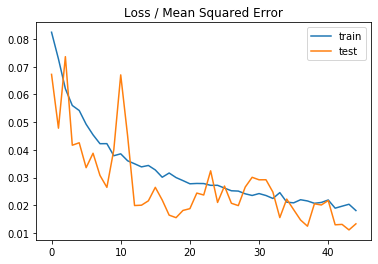

In [20]:
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'][5:], label='train')
plt.plot(history.history['val_loss'][5:], label='test')
plt.legend()

In [45]:
model_json = model.to_json()
with open("NRLMSIS_POD.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("NRLMSIS_POD.h5")
print("Saved model")

Saved model


In [4]:
with open('NRLMSIS_POD.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('NRLMSIS_POD.h5')
model_NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               3960      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

[[0.01910589 0.03859738 0.05566112 0.07296264 0.09129732 0.11086553
  0.13168374 0.15353721 0.17637091 0.20019298 0.22493738 0.2506661
  0.27742588 0.30526723 0.33428826 0.36455454 0.39606095 0.42883255
  0.46284592 0.49801013 0.53430565 0.5717718  0.61046829 0.65057239
  0.69240503 0.73587109 0.78104994 0.82791141 0.87632522 0.92618242
  0.97733512 1.02963259 1.08302015 1.13745554 1.19291065 1.24947342
  1.30721558 1.36619372 1.42650244 1.48816937 1.55116343 1.61544224
  1.68088995 1.74738424 1.81485383 1.88328172 1.95274038 2.02347528]]
[[0.07305868 0.24968109 0.50132127 0.81156031 1.14609684 1.48499501
  1.82318036 2.1372827  2.41828876 2.67134649 2.88363015 3.0541826
  3.19334613 3.29812593 3.37419468 3.43651552 3.48163513 3.51471783
  3.55000519 3.58488764 3.62534868 3.68575168 3.76321679 3.86143462
  3.9910655  4.14292196 4.31366095 4.50500352 4.70282809 4.89927578
  5.09400999 5.27434484 5.43599359 5.58351427 5.71018201 5.81677524
  5.91072036 5.98966743 6.05664165 6.11945006 6.

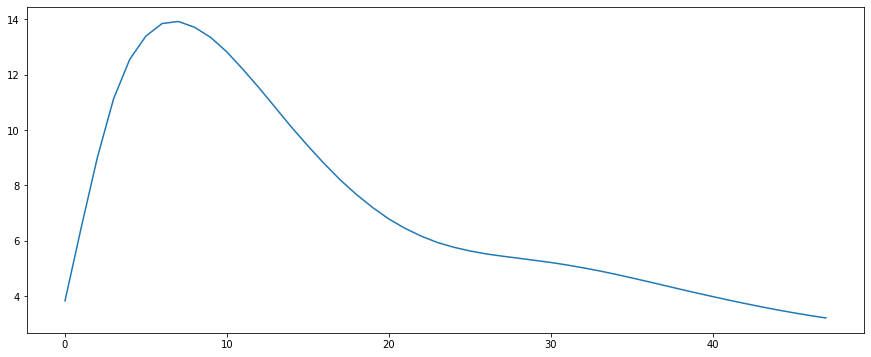

In [5]:
mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

prediction_NN = np.empty((15778,10))
prediction_POD = np.empty((15778,10))

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_NN[0][b] = np.sum(np.square(y_test_NN-y_pred))/(y_pred.shape[1]*y_pred.shape[0])
    mse2 = np.sum(np.square(y_pred-y_test_NN),axis = 1)
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

for a in range(pred_number):
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    prediction_POD = np.append(prediction_POD, XfullPred, axis =0)
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_ROM[0][a] = np.sum(np.square(errFullPred))/(errFullPred.shape[1]*errFullPred.shape[0])
    mse_rom2 = np.sum(np.square(errFullPred),axis = 1)
    
print(mse_ROM) 

factor = np.divide(np.transpose(mse_ROM), np.transpose(mse_NN))
plt.figure(figsize = (15,6))
plt.plot(factor)

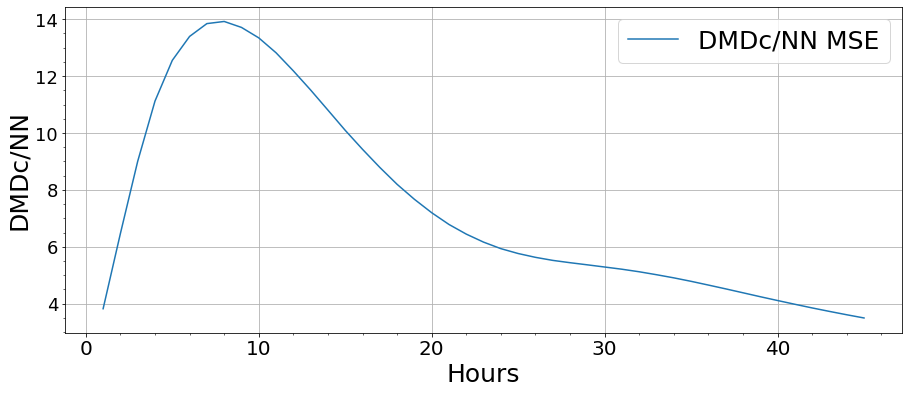

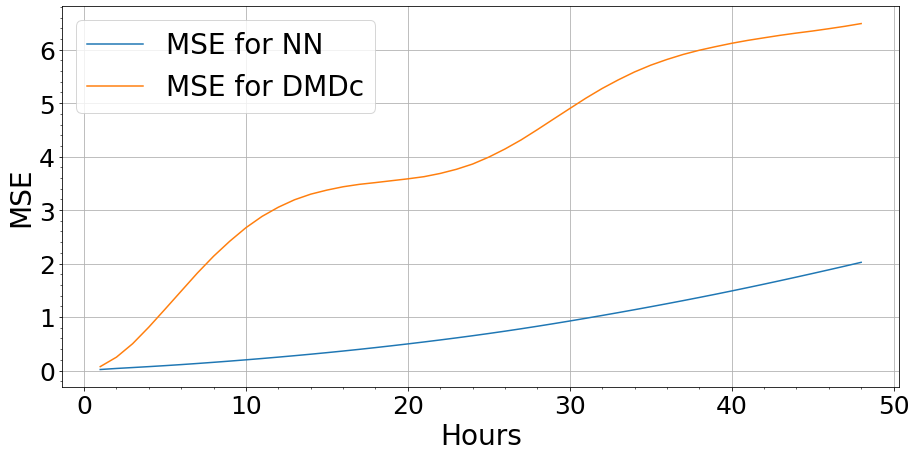

In [9]:
plt.figure(figsize = (15,6))
#plt.title("NRLMSISE 1997-2008: DMDc/NN MSE for 24 Hours Time Series using POD")
plt.plot(range(1,1+len(factor[:-3])),factor[:-3], label = "DMDc/NN MSE")
plt.grid()
plt.minorticks_on()
plt.legend(fontsize=25)
plt.xlabel("Hours", fontsize=25)
plt.ylabel("DMDc/NN", fontsize=25)
plt.xticks(size = 20)
plt.yticks(size = 18)
plt.savefig('POD_NRLMSISE_ratio_48.png')  
#plt.show()


plt.figure(figsize = (15,7))
#plt.title("NRLMSISE 1997-2008: Comparison of MSE for 24 Hours Time Series using POD")
plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
plt.xlabel("Hours",fontsize=28)
plt.ylabel("MSE",fontsize=28)
plt.legend(fontsize=28)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.savefig('POD_NRLMSISE_both_48.png')
#plt.show()

In [20]:
x_test_NN = x_test[0,:]
x_test_NN= np.reshape(x_test_NN, (1, 32))
x_test_rom = np.reshape(x_test[0,:10], (1, 10))

NN_prediction = None
for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    if b == 0:
        NN_prediction = y_pred
    else:
        NN_prediction = np.append(NN_prediction, y_pred, axis = 0)
    sw_data_test = np.reshape(sw_data[b,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[b+1,:],(1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)
    
DMDc_prediction = None
for a in range(pred_number):
    #General
    sw_data_test = np.reshape(sw_data[a,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[a+1,:], (1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_rom = np.transpose(np.matmul(A,np.transpose(x_test_rom)) + np.matmul(B,np.transpose(sw_data_test)))
    if not a:
        DMDc_prediction = x_test_rom
    else:
        DMDc_prediction = np.append(DMDc_prediction, x_test_rom, axis = 0)

In [21]:
print(y_test.shape)
print(x_test.shape)
actual = y_test[:pred_number,:]
print(actual.shape)
NN_error = (NN_prediction-actual)
DMDc_error = (DMDc_prediction-actual)
print(np.sum(np.square(NN_error))/(NN_error.shape[0]*NN_error.shape[1]))
print(np.sum(np.square(DMDc_error))/(DMDc_error.shape[0]*DMDc_error.shape[1]))
print(NN_error.shape)
print(DMDc_error.shape)

(15778, 10)
(15778, 32)
(48, 10)
6.291921271542056
13.40026967450343
(48, 10)
(48, 10)


In [27]:
u = data.get("U100")
densityDataMeanLog = data.get("densityDataMeanLog")

In [28]:
nndecoded = np.matmul(u[:,:r], NN_prediction.T)
DMDcdecoded = np.matmul(u[:,:r], DMDc_prediction.T)
actualdecoded = np.matmul(u[:,:r], actual.T)
NN_error_decoded = np.matmul(u[:,:r], NN_error.T)
DMDc_error_decoded = np.matmul(u[:,:r], DMDc_error.T)

In [29]:
matrixof10 = np.full((17280, pred_number), 10)
print((nndecoded+densityDataMeanLog).shape)
densityNNPred = np.power(matrixof10,(nndecoded+densityDataMeanLog)).T
densityDMDcPred = np.power(matrixof10,(DMDcdecoded+densityDataMeanLog)).T
actualPred = np.power(matrixof10,(actualdecoded+densityDataMeanLog)).T
densityNNPred_Error = np.power(matrixof10,(NN_error_decoded+actualdecoded+densityDataMeanLog)).T-actualPred
densityDMDcPred_Error = np.power(matrixof10,(DMDc_error_decoded+actualdecoded+densityDataMeanLog)).T-actualPred
print(densityNNPred.shape)

(17280, 48)
(48, 17280)


/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/maggiezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (T

<Figure size 432x288 with 0 Axes>

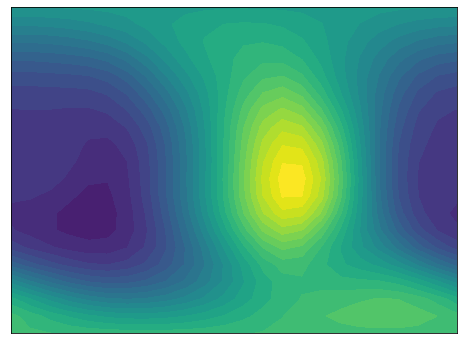

<Figure size 432x288 with 0 Axes>

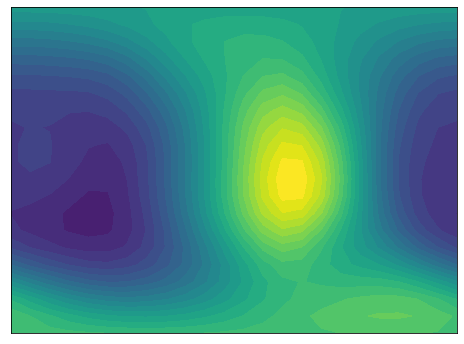

<Figure size 432x288 with 0 Axes>

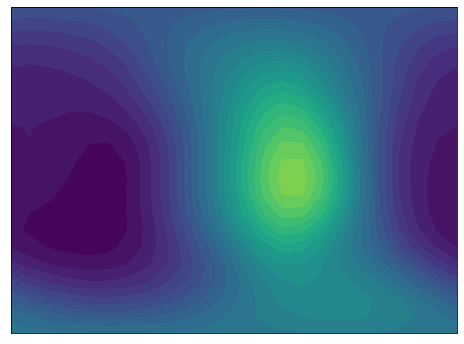

<Figure size 432x288 with 0 Axes>

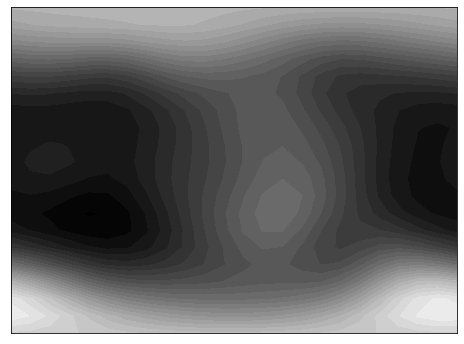

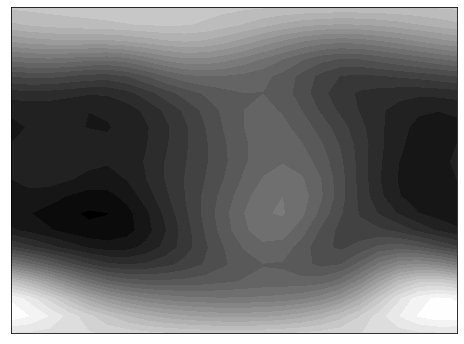

<Figure size 432x288 with 0 Axes>

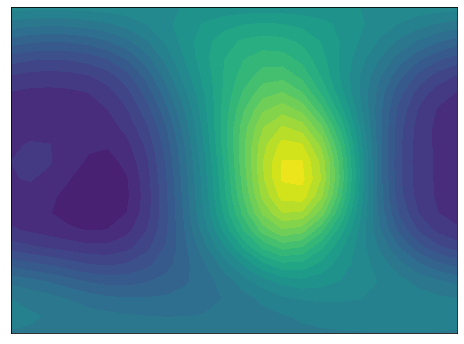

<Figure size 432x288 with 0 Axes>

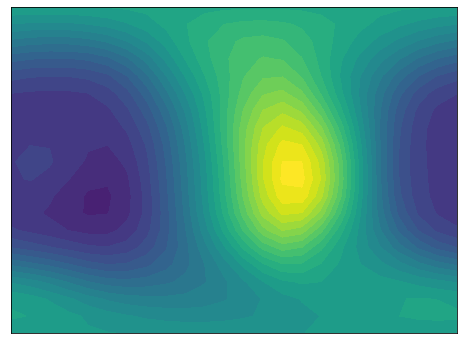

<Figure size 432x288 with 0 Axes>

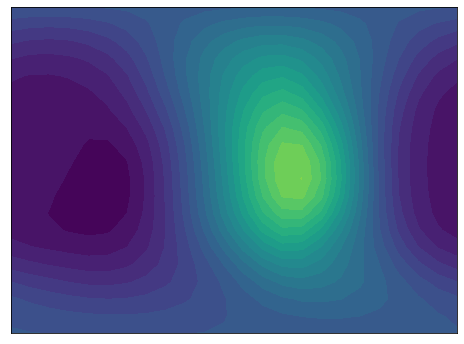

<Figure size 432x288 with 0 Axes>

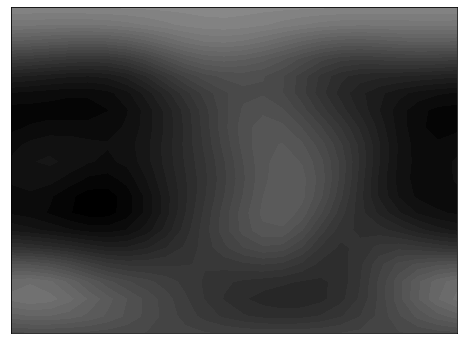

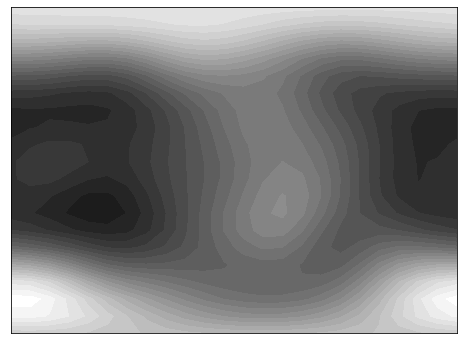

<Figure size 432x288 with 0 Axes>

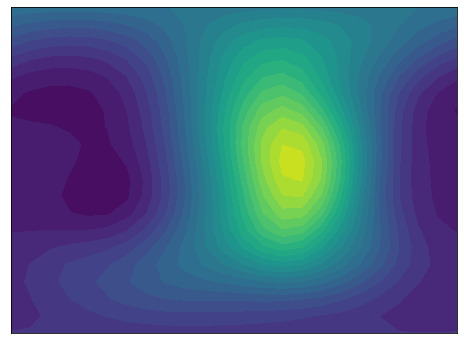

<Figure size 432x288 with 0 Axes>

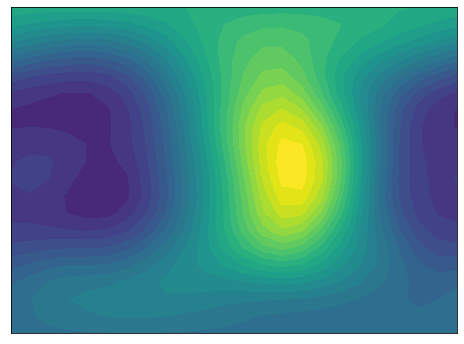

<Figure size 432x288 with 0 Axes>

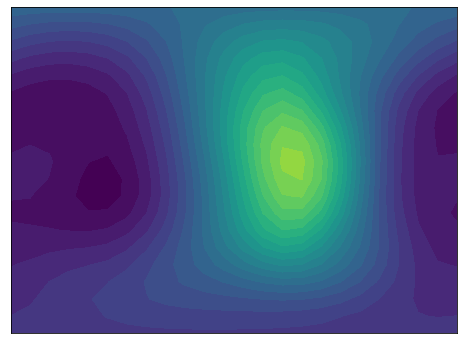

<Figure size 432x288 with 0 Axes>

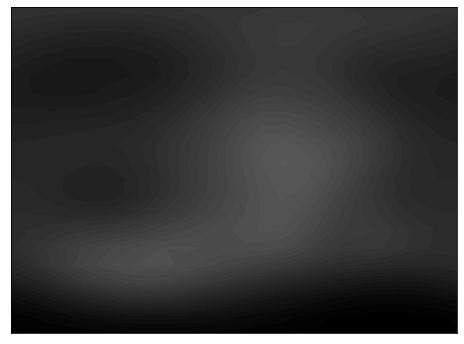

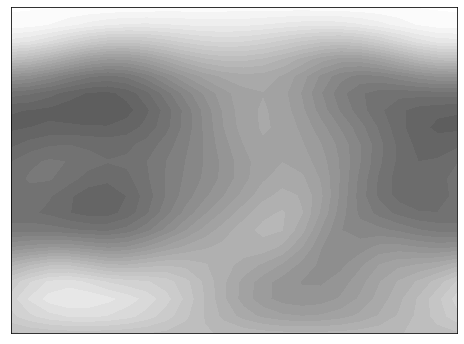

<Figure size 432x288 with 0 Axes>

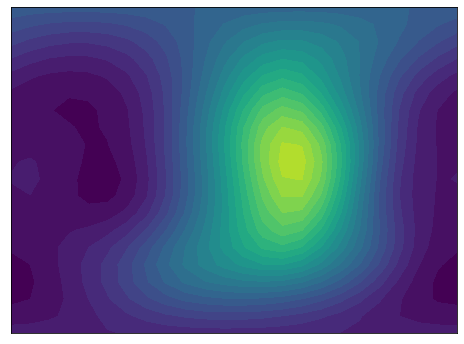

<Figure size 432x288 with 0 Axes>

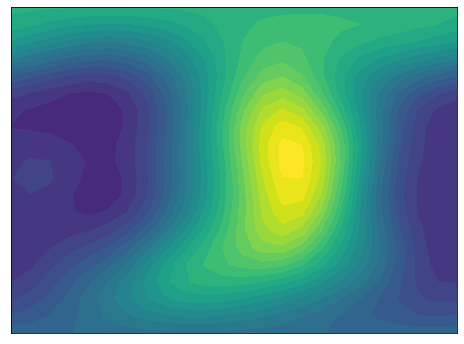

<Figure size 432x288 with 0 Axes>

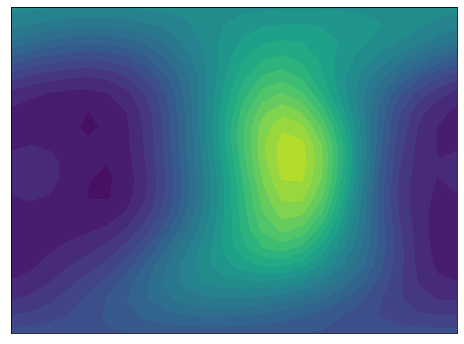

<Figure size 432x288 with 0 Axes>

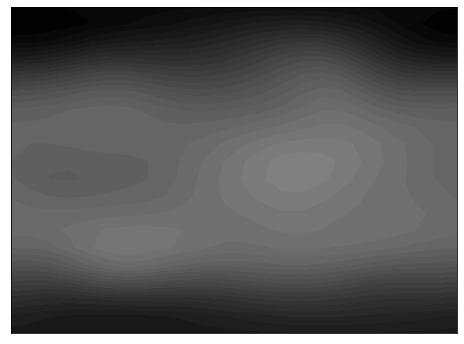

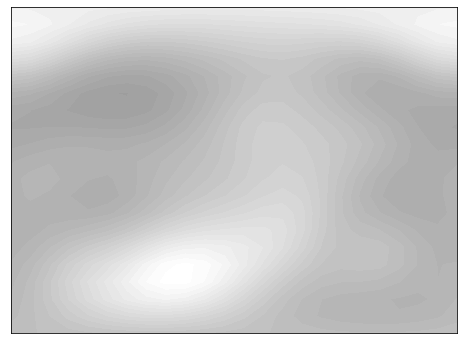

<Figure size 432x288 with 0 Axes>

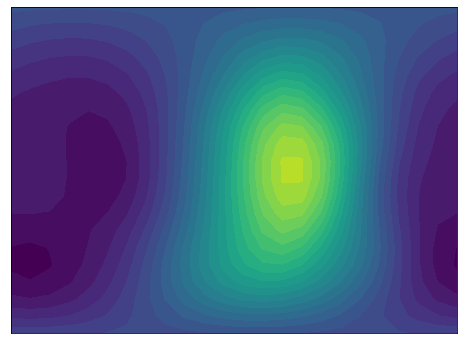

<Figure size 432x288 with 0 Axes>

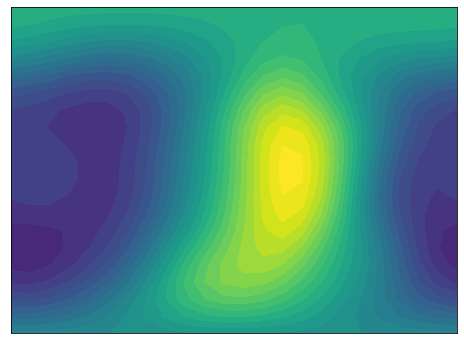

<Figure size 432x288 with 0 Axes>

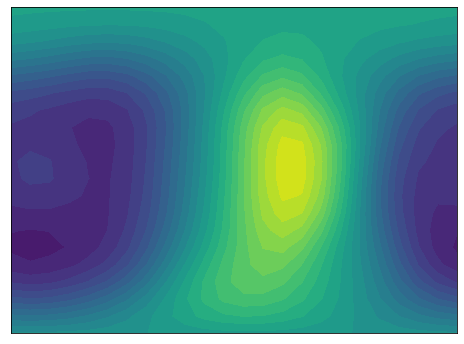

<Figure size 432x288 with 0 Axes>

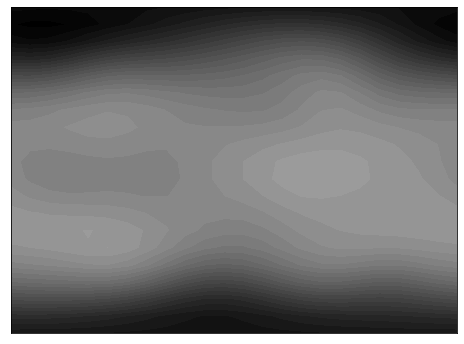

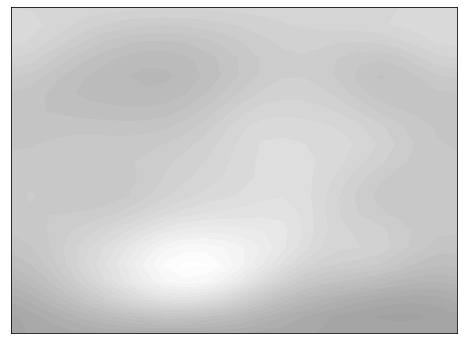

<Figure size 432x288 with 0 Axes>

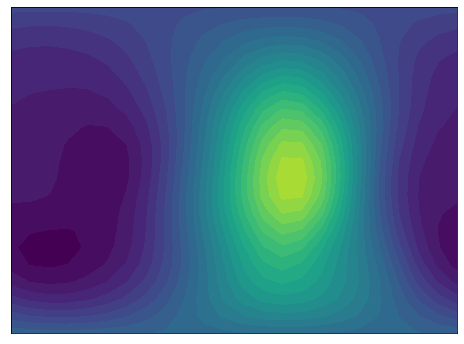

<Figure size 432x288 with 0 Axes>

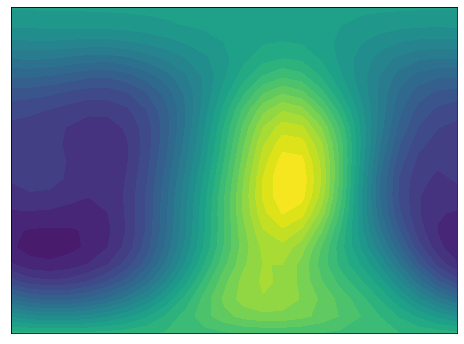

<Figure size 432x288 with 0 Axes>

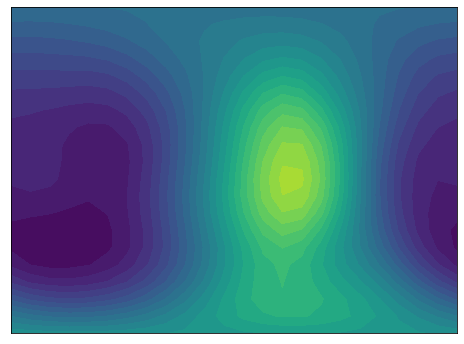

<Figure size 432x288 with 0 Axes>

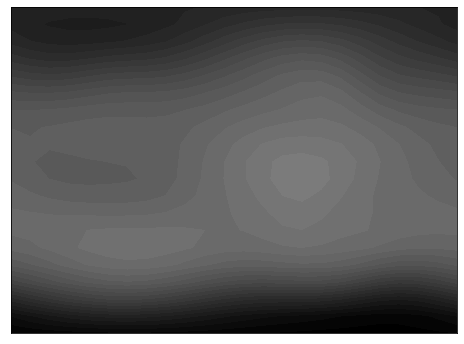

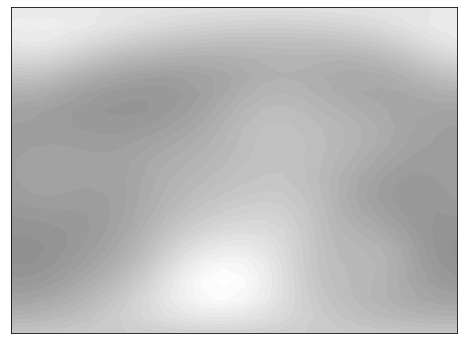

<Figure size 432x288 with 0 Axes>

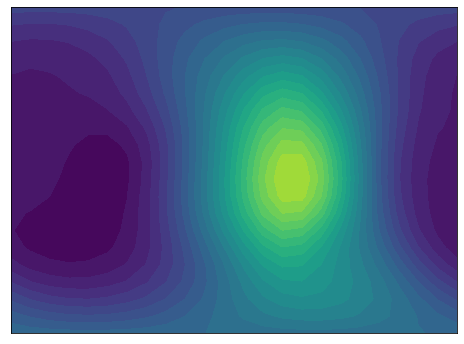

<Figure size 432x288 with 0 Axes>

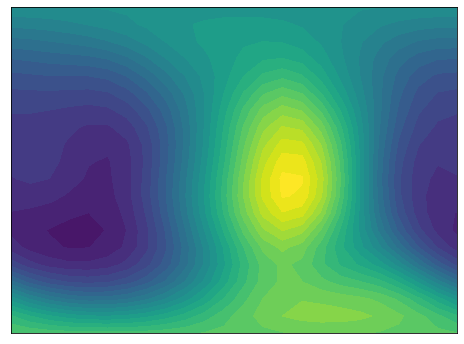

<Figure size 432x288 with 0 Axes>

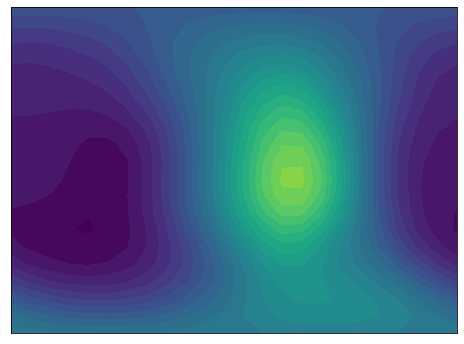

<Figure size 432x288 with 0 Axes>

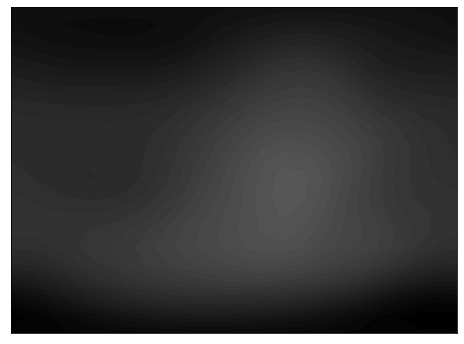

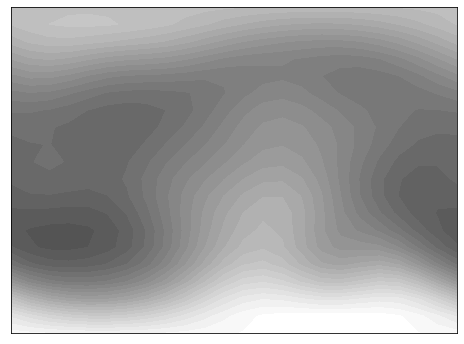

In [36]:
hours = [0,3,7,11,15,19,23]
for h in hours:
    nndecoded_1 = np.reshape(densityNNPred[h,:], (24, 20, 36), order = "f")
    DMDcdecoded_1 = np.reshape(densityDMDcPred[h,:], (24, 20, 36), order = "f")
    actual_1 = np.reshape(actualPred[h,:], (24, 20, 36), order = "f")
    #actual_1 = np.reshape(dens_data.T[:,split_15-pred_number+h],(24, 20, 36), order = "f")
    
    nn_error = np.reshape(densityNNPred_Error[h,:], (24, 20, 36), order = "f") #np.divide((nndecoded_1-actualPred_1),actualPred_1)
    dmdc_error = np.reshape(densityDMDcPred_Error[h,:], (24, 20, 36), order = "f") # np.divide((DMDcdecoded_1-actualPred_1),actualPred_1)
    #print(densityNNPred[:,:,18])
    
    plt.figure()
    
    fig, ax1 = plt.subplots( figsize=(8,6))
    #ax1.set_title("1x1 Decoded NRLMSISE NN Prediction Hour: "+str(h+1))
    CS1 = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nndecoded_1[:,:,18].T, levels = 25,vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    #CS2 = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, 10**DMDcdecoded_1[:,:,18].T, 25, extend = "both")
    #ax1.set_xlabel('Local solar time [hours]')
    #ax1.set_ylabel('Latitude [deg]')
    #norm = mpl.colors.Normalize(vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    #cbar = fig.colorbar(CS1, ax = ax1, norm = norm)
    #cbar.ax.set_ylabel('Density [kg/m^3]')
    #CS1.set_clim(vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    plt.savefig("NRLMSISE_ROM_NN_Prediction_Hour"+str(h+1)+".png")
    
    plt.figure()
    #fig, ax = plt.subplots(constrained_layout=True)
    fig, ax2 = plt.subplots( figsize=(8,6))
    #ax2.set_title("1x1 Decoded NRLMSISE DMDc Prediction Hour: "+str(h+1))
    CS2 = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, DMDcdecoded_1[:,:,18].T, levels = 25,vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    '''
    ax2.set_xlabel('Local solar time [hours]')
    ax2.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS2, ax = ax2, norm = norm)
    cbar.ax.set_ylabel('Density [kg/m^3]')
    CS2.set_clim(vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    #'''
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    plt.savefig("NRLMSISE_ROM_DMDc_Prediction_Hour"+str(h+1)+".png")
    
    
    plt.figure()
    fig, ax3 = plt.subplots(figsize=(8,6))
    #ax3.set_title("1x1 Decoded NRLMSISE DMDc Prediction Hour: "+str(h+1))
    CS3 = ax3.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, actual_1[:,:,18].T, levels = 25,vmin = min(np.amin(actual_1[:,:,18]), np.amin(nndecoded_1[:,:,18]),np.amin(DMDcdecoded_1[:,:,18])), vmax = max(np.amax(actual_1[:,:,18]), np.amax(nndecoded_1[:,:,18]),np.amax(DMDcdecoded_1[:,:,18])))
    '''
    ax3.set_xlabel('Local solar time [hours]')
    ax3.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS3, ax = ax3)
    cbar.ax.set_ylabel('Density [kg/m^3]')
    #'''
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)
    plt.savefig("NRLMSISE_ROM_Actual_Hour"+str(h+1)+".png")
    
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(8,6))
    #ax1.set_title("1x1 Decoded NRLMSISE NN Prediction Error Hour: "+str(h+1))
    CS = ax1.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, nn_error[:,:,18].T, cmap = "gray",levels = 25,vmin = min(np.amin(nn_error[:,:,18]),np.amin(dmdc_error[:,:,18])), vmax = max(np.amax(nn_error[:,:,18]),np.amax(dmdc_error[:,:,18])))
    '''
    ax1.set_xlabel('Local solar time [hours]')
    ax1.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS, ax = ax1)
    cbar.ax.set_ylabel('Percent Error [%]')
    #'''
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    plt.savefig("NRLMSISE_POD_NN_Error_Hour"+str(h+1)+".png")
    
    fig, ax2 = plt.subplots(figsize=(8,6))
    #ax2.set_title("1x1 Decoded NRLMSISE DMDc Prediction Error Hour: "+str(h+1))
    CS = ax2.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, dmdc_error[:,:,18].T, cmap = "gray",levels = 25,vmin = min(np.amin(nn_error[:,:,18]),np.amin(dmdc_error[:,:,18])), vmax = max(np.amax(nn_error[:,:,18]),np.amax(dmdc_error[:,:,18])))
    '''
    ax2.set_xlabel('Local solar time [hours]')
    ax2.set_ylabel('Latitude [deg]')
    cbar = fig.colorbar(CS, ax = ax2)
    cbar.ax.set_ylabel('Percent Error [%]')
    #'''
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    plt.savefig("NRLMSISE_POD_DMDc_Error_Hour"+str(h+1)+".png")
    